# Stacked Model

In [2]:
import numpy as np
import pandas as pd
import missingno as msno
from sklearn import metrics
import matplotlib.pyplot as plt

import os
os.chdir("F:/Defi_IA/data")

import warnings
warnings.filterwarnings('ignore')

## Sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, log_loss

## Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline

## Model
from lightgbm import LGBMRegressor, plot_importance, plot_metric
from catboost import CatBoostRegressor, MetricVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#Ensembles
from sklearn.ensemble import BaggingRegressor

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Catboost
import catboost as cbt

# model selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score

## Read data

In [98]:
df = pd.read_csv("Dataset/weather_observed_forecast_no_inter.csv")
#df = pd.read_csv("Dataset/weather_observed_forecast_inter.csv")
test_observation = pd.read_csv("Test/Baselines/Baseline_observation_test.csv").rename(columns = {"Id": "id"})[['id']] #For check Kaggle y prediction
df['y'] = np.where(df.test, -1, df.y)
df['error'] = df.y - df.Forecast

### Model error prediction

In [130]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# The "test" column is a boolean column which is equal to True for test and False for train.
X = df[df["test"] == False].copy()
X_kaggle = df[df["test"]].copy()

X.dropna(inplace=True)
for col in X_kaggle.select_dtypes(include=np.number):
    X_kaggle[col] = X_kaggle[col].fillna(X_kaggle[col].mean())

# y_train is the target variable to train our model.
y = X['error'].astype(float).copy()
#y = X['y'].astype(float).copy()

X_kaggle["id"] = X_kaggle["station"].astype(str) + "_" + X_kaggle["day_index"].astype(str)
X_kaggle = X_kaggle[X_kaggle.id.isin(test_observation.id)]
X_kaggle = X_kaggle.set_index("id")

columns_to_drop = ['y', 'test', 'day_index', 'error', 'day', 'station']
#columns_to_drop = ['y', 'test', 'day_index', 'day', 'error', 'station']

X = X.drop(columns_to_drop, axis = "columns")
X_kaggle = X_kaggle.drop(columns_to_drop, axis = "columns")

categorical_features = ['saison']
columns_to_scale = list(set(X.columns) - set(['Forecast'] + categorical_features))
X[columns_to_scale] = MinMaxScaler().fit_transform(X[columns_to_scale])
X_kaggle[columns_to_scale] = MinMaxScaler().fit_transform(X_kaggle[columns_to_scale])

X = pd.get_dummies(X, columns=categorical_features)
X_kaggle = pd.get_dummies(X_kaggle, columns=categorical_features)

#for feature in categorical_features:
#    X[feature] = pd.Categorical(X[feature])
#    X_kaggle[feature] = pd.Categorical(X_kaggle[feature])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.01, random_state=4
)

X_kaggle.dropna(inplace=True)
X_train_forecast, X_test_forecast, X_kaggle_forecast = X_train[['Forecast']], X_test[['Forecast']], X_kaggle[['Forecast']]

X_train.drop(['Forecast'], axis=1, inplace=True)
X_test.drop(['Forecast'], axis=1, inplace=True)
X_kaggle.drop(['Forecast'], axis=1, inplace=True)

X_train.head()

,month,Observation,mean_ws,std_ws,mean_p3031,std_p3031,mean_u10,std_u10,mean_v10,std_v10,...,max_dd,min_dd,latitude,longitude,height,coef_saison,saison_Autumn,saison_Spring,saison_Summer,saison_Winter
59714,0.363636,0.005277,0.444666,0.151975,0.553834,0.038799,0.534297,0.124443,0.742607,0.071705,...,0.588889,0.491379,0.504737,0.139129,0.184211,0.166667,0,0,1,0
155950,0.363636,0.000000,0.265339,0.290556,0.386543,0.505405,0.340223,0.352409,0.417058,0.160864,...,0.966667,0.077586,0.277562,0.332435,0.003289,0.166667,0,0,1,0
18332,0.000000,0.217678,0.549691,0.206353,0.612203,0.124853,0.651167,0.373790,0.723408,0.181175,...,0.722222,0.531609,0.540482,0.224791,0.174342,0.833333,0,0,0,1
210316,0.636364,0.000000,0.339687,0.205489,0.381422,0.777682,0.385780,0.306671,0.263905,0.061684,...,0.513889,0.034483,0.081395,0.386895,0.098684,0.333333,0,0,1,0
146018,0.181818,0.000000,0.204210,0.248228,0.616183,0.522509,0.537235,0.260711,0.469206,0.189697,...,0.983333,0.175287,0.210594,0.260956,0.105263,0.500000,0,1,0,0


In [80]:
print(X_train.shape)
print(X_test.shape)
print(X_kaggle.shape)
X_train.head(10)

(97124, 68)
(982, 68)
(85140, 68)


,month,Observation,Forecast,mean_ws,std_ws,mean_p3031,std_p3031,mean_u10,std_u10,mean_v10,...,max_dd,min_dd,latitude,longitude,height,coef_saison,saison_Autumn,saison_Spring,saison_Summer,saison_Winter
88376,0.727273,0.000000,0.000000e+00,0.222891,0.142270,0.727340,0.305393,0.548697,0.186582,0.468602,...,0.609095,0.425287,0.144672,0.841441,0.300000,0.500000,1,0,0,0
39326,0.545455,0.000000,2.727387e+00,0.211355,0.251967,0.605560,0.118541,0.547397,0.162750,0.562242,...,0.527954,0.378601,0.430355,0.836335,0.468421,0.166667,0,0,1,0
131801,0.909091,0.007564,1.931455e+01,0.437925,0.131141,0.841075,0.074011,0.694830,0.029904,0.316314,...,0.664842,0.732759,0.718622,0.509715,0.347368,0.833333,1,0,0,0
25716,1.000000,0.000840,4.795067e-18,0.063440,0.042146,0.400422,0.177049,0.429783,0.049628,0.491577,...,0.491405,0.000000,0.655759,0.773082,0.315789,1.000000,0,0,0,1
118162,0.181818,0.022303,5.090176e-01,0.310475,0.163445,0.528301,0.162821,0.471241,0.220143,0.644314,...,0.500653,0.422969,0.180194,0.584314,0.257895,0.500000,0,1,0,0
148435,0.000000,0.000000,0.000000e+00,0.291419,0.112511,0.224410,0.034231,0.271511,0.065332,0.416436,...,0.239508,0.192529,0.287836,0.220678,0.102632,0.833333,0,0,0,1
175239,0.090909,0.015127,1.093049e+01,0.398557,0.330387,0.533851,0.138374,0.495525,0.386410,0.689874,...,0.536829,0.413793,0.300969,0.729826,0.236842,0.666667,0,0,0,1
176771,0.454545,0.000000,0.000000e+00,0.155496,0.301186,0.762566,0.387542,0.541974,0.181738,0.423753,...,0.631807,0.195402,0.392680,0.685293,0.536842,0.000000,0,0,1,0
151420,0.545455,0.000000,4.534240e+00,0.196601,0.119706,0.829927,0.120847,0.570318,0.115469,0.412905,...,0.683425,0.660920,0.374812,0.303645,0.323684,0.166667,0,0,1,0
50866,0.272727,0.005042,0.000000e+00,0.402307,0.166107,0.751030,0.707728,0.531396,0.270133,0.222995,...,0.743302,0.028736,0.461356,0.000000,0.094737,0.333333,0,1,0,0


In [96]:
# Custom MAPE
def MAPE(y_true, y_pred):
    return metrics.mean_absolute_percentage_error(y_true + 1, y_pred + 1)

def MAPE_Error(y_true, y_pred, forecast):
    #return metrics.mean_absolute_percentage_error(y_true + 1, y_pred + 1)
    return metrics.mean_absolute_percentage_error(y_true + forecast + 1, y_pred + forecast + 1)

def model_results(model):
    print(f"MAPE on train set: {MAPE_Error(y_train, model.predict(X_train), X_train_forecast.Forecast)}")
    print(f"MAPE on test set: {MAPE_Error(y_test, model.predict(X_test), X_test_forecast.Forecast)}")
    print(f"MAPE Forecast on train set: {MAPE_Error(0, model.predict(X_train), X_train_forecast.Forecast)}")
    print(f"MAPE Forecast on test set: {MAPE_Error(0, model.predict(X_test), X_test_forecast.Forecast)}")
    print(f"MAPE Forecast on kaggle set: {MAPE_Error(0, model.predict(X_kaggle), X_kaggle_forecast.Forecast)}")

### LightGBM

In [129]:
import lightgbm as lgbm

from sklearn import model_selection
from sklearn import metrics

#  Fold:
k = 5

cv = model_selection.KFold(k, shuffle=True, random_state=42)

model = lgbm.LGBMRegressor(
    n_estimators=3000, # Number of trees
    objective="l2",
    random_state=42,
    metrics='mean_absolute_percentage_error',
)

error_validation = 0

sub_test = pd.Series(0.0, index=X_test.index)
sub_kaggle = pd.Series(0.0, index=X_kaggle.index)

for fit_idx, val_idx in cv.split(X_train, y_train):

    X_fit = X_train.iloc[fit_idx]
    X_val = X_train.iloc[val_idx]
    
    y_fit = y_train.iloc[fit_idx] 
    y_val = y_train.iloc[val_idx]

    model.fit(
        X_fit,
        y_fit,
        eval_set=[(X_fit, y_fit), (X_val, y_val)],
        eval_names=("fit", "val"),
        eval_metric="l2",
        feature_name=X_fit.columns.tolist(),
        verbose=1000,
    )
    
    # Validation predictions:
    #error_validation += MAPE(y_val, model.predict(X_val)) / k
    forecast_val = X_train_forecast[X_train_forecast.index.isin(X_val.index)].Forecast
    error_validation += MAPE_Error(y_val, model.predict(X_val), forecast_val) / k
    
    # Bagging
    # Since we train 5 models using cross-validation with k=5 folds, we average the prediction of each models.
    # It helps a lot!
    sub_test += model.predict(X_test) / k
    sub_kaggle += (model.predict(X_kaggle) + X_kaggle_forecast.Forecast) / k

sub_kaggle += 1

model_results(model)

#0.3351
#0.3

#0.3822
#0.4103
#0.3761

#0.38970415278013126

[1000]	fit's l2: 0.854944	fit's mape: 0.286701	val's l2: 5.60528	val's mape: 0.480191
[2000]	fit's l2: 0.315038	fit's mape: 0.202866	val's l2: 5.53116	val's mape: 0.486711
[3000]	fit's l2: 0.142162	fit's mape: 0.148898	val's l2: 5.51277	val's mape: 0.490761
[1000]	fit's l2: 0.855766	fit's mape: 0.28803	val's l2: 5.11354	val's mape: 0.474855
[2000]	fit's l2: 0.308271	fit's mape: 0.204484	val's l2: 5.00975	val's mape: 0.480988
[3000]	fit's l2: 0.136173	fit's mape: 0.148205	val's l2: 4.98236	val's mape: 0.483722
[1000]	fit's l2: 0.866588	fit's mape: 0.286869	val's l2: 5.36792	val's mape: 0.476935
[2000]	fit's l2: 0.311575	fit's mape: 0.202883	val's l2: 5.31595	val's mape: 0.484986
[3000]	fit's l2: 0.133663	fit's mape: 0.147824	val's l2: 5.31157	val's mape: 0.489074
[1000]	fit's l2: 0.868012	fit's mape: 0.287625	val's l2: 5.30675	val's mape: 0.475629
[2000]	fit's l2: 0.327061	fit's mape: 0.204324	val's l2: 5.23179	val's mape: 0.484356
[3000]	fit's l2: 0.14635	fit's mape: 0.150067	val's l2:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

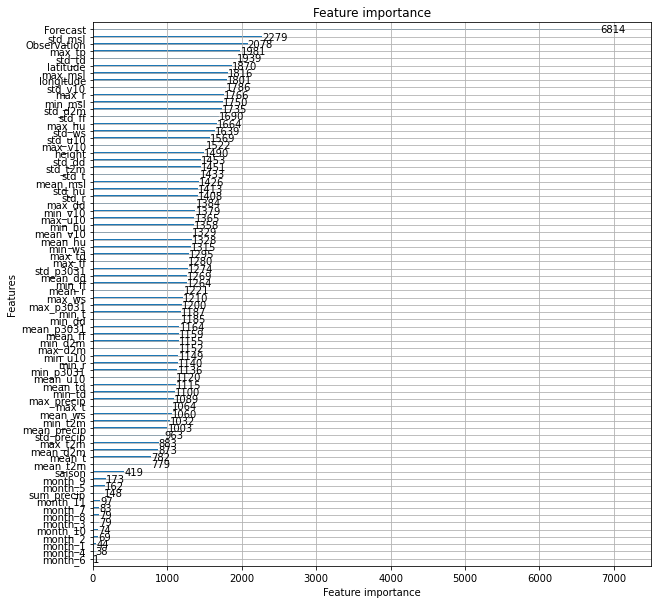

In [17]:
plot_importance(model._Booster, figsize=(10, 10))

MAPE on train set: 0.41203357586992884
MAPE on test set: 0.4323749254085725
MAPE Forecast on train set: 0.10471722165063675
MAPE Forecast on test set: 0.10199272762044877
MAPE Forecast on kaggle set: 0.13032220497650127
-0.1969763866886645
-0.1993251007844568
-0.256884171301283


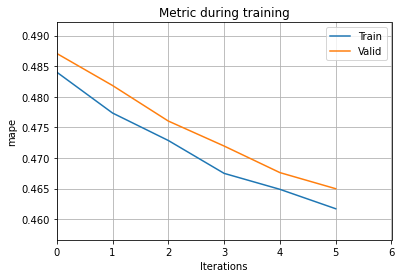

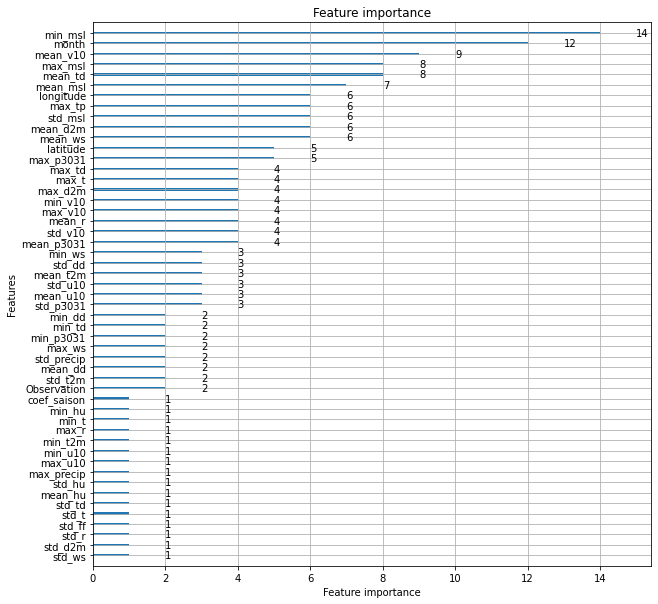

In [135]:
lgbm_params = {
    "metric":'mean_absolute_percentage_error',
    "n_estimators":6,
}

fit_params = {
    "eval_set" : [(X_test,y_test),(X_train,y_train)],
    'eval_names': ["Valid", "Train"],
}

model_lgbm = LGBMRegressor(**lgbm_params)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model_lgbm.fit(X_train, y_train, **fit_params, verbose=False)

plot_metric(model_lgbm) # Graph for the binary_logloss evolution
plot_importance(model_lgbm._Booster, figsize=(10, 10))

model_results(model_lgbm)

print(model_lgbm.predict(X_train).mean())
print(model_lgbm.predict(X_test).mean())
print(model_lgbm.predict(X_kaggle).mean())

In [136]:
from sklearn.ensemble import BaggingRegressor

lgbm_params = {
    "metric":'mean_absolute_percentage_error',
    "n_estimators":6,
    "objective":"l2",
}

bagging_lgbm = BaggingRegressor(LGBMRegressor(**lgbm_params), n_estimators=5)
bagging_lgbm.fit(X_train, y_train)
model_results(bagging_lgbm)

MAPE on train set: 0.41228142050593897
MAPE on test set: 0.4331635036760708
MAPE Forecast on train set: 0.10488791276025472
MAPE Forecast on test set: 0.10440741896790698
MAPE Forecast on kaggle set: 0.14324865483577157


In [109]:
from sklearn.ensemble import BaggingRegressor

catboost_params = {
    "iterations":10,
    "eval_metric":'MAPE',
    "verbose":False,
}

catboost_model = CatBoostRegressor(**catboost_params)

catboost_model.fit(X_train, y_train)

model_results(catboost_model)

MAPE on train set: 0.41532033277278807
MAPE on test set: 0.4211431612502403
MAPE Forecast on train set: 0.16040402409736107
MAPE Forecast on test set: 0.15913304343410684
MAPE Forecast on kaggle set: 0.21856514959372278


In [113]:
from sklearn.svm import LinearSVR
svr_model = BaggingRegressor(LinearSVR(), n_estimators=10)
svr_model.fit(X_train, y_train)
model_results(svr_model)

MAPE on train set: 0.3057316159058081
MAPE on test set: 0.3242985684582466
MAPE Forecast on train set: 0.09415600428374872
MAPE Forecast on test set: 0.09858788863229667
MAPE Forecast on kaggle set: 0.10278418039715377


In [66]:
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

estimators = [
    ('svr', svr_model),
    #('lgbm', model_lgbm),
    #('catboost', cb_model),
    #('rf', DecisionTreeRegressor()),
    ('knn', KNeighborsRegressor()),
]

stacking_model = StackingRegressor(estimators, final_estimator=RandomForestRegressor(), cv=2)
stacking_model.fit(X_train, y_train)

model_results(stacking_model)

MAPE on train set: 0.3745549931166352
MAPE on test set: 0.4171121948366944
MAPE Forecast on train set: 0.21741141955815751
MAPE Forecast on test set: 0.2273303949603192
MAPE Forecast on kaggle set: 0.320269358832355


In [117]:
y_predict = svr_model.predict(X_test.fillna(0))
prediction_test = X_test[['Forecast']].copy()
prediction_test['Prediction'] = y_predict + prediction_test.Forecast.fillna(0)
prediction_test['Prediction'] = np.where(prediction_test.Prediction<0, 0, prediction_test.Prediction)

print(prediction_test.shape)
assert(prediction_test.Prediction.isna().any() == False)

error = MAPE(prediction_test[~prediction_test.Forecast.isna()].Forecast, prediction_test[~prediction_test.Forecast.isna()].Prediction)
print(f"MAPE Forecast-Prediction: {error}")

prediction_test.head()

(778, 2)
MAPE Forecast-Prediction: 0.09771846592085423


,Forecast,Prediction
3053,0.000000,0.012098
27931,0.011921,0.000000
170668,0.000000,0.000000
151732,0.925519,0.660661
110810,0.000000,0.000000


In [118]:
y_kaggle = svr_model.predict(X_kaggle)
model_results(svr_model)

MAPE on train set: 0.3057316159058081
MAPE on test set: 0.3242985684582466
MAPE Forecast on train set: 0.09415600428374872
MAPE Forecast on test set: 0.09858788863229667
MAPE Forecast on kaggle set: 0.10278418039715377


In [119]:
prediction = X_kaggle.reset_index()[['id', 'Forecast']].copy()
prediction['Prediction'] = y_kaggle + prediction.Forecast
prediction['Prediction'] = np.where(prediction.Prediction<0, 0, prediction.Prediction)
prediction['Prediction'] = prediction['Prediction'] + 1

print(prediction.shape)
assert(prediction.shape[0] == 85140)
assert(prediction.Prediction.isna().any() == False)
prediction[['id', 'Prediction']].to_csv('submission.csv', index=False)

error = MAPE(prediction[~prediction.Forecast.isna()].Forecast, prediction[~prediction.Forecast.isna()].Prediction - 1)
error = MAPE(prediction.Forecast, prediction.Prediction - 1)
print(f"MAPE Forecast-Prediction: {error}")

prediction.head(30)

(85140, 3)
MAPE Forecast-Prediction: 0.10278418039715377


,id,Forecast,Prediction
0,14047002_31,0.003304,0.995718
1,14047002_39,3.726310,3.771634
2,14047002_100,4.361040,4.182076
3,14047002_223,0.000000,1.027962
4,14047002_236,4.294544,4.153166
5,14047002_256,8.192842,6.858338
6,14047002_281,7.541862,6.410961
7,14047002_283,2.112499,2.602939
8,14047002_293,0.078668,1.060213
9,14066001_0,0.004197,1.001625


In [133]:
#Forecast
test_forecast = pd.read_csv(
    "Test/Baselines/Baseline_forecast_test.csv",
    dtype = {"Prediction": float}
).rename(columns = {"Prediction": "Forecast", "Id": "id"})[['id', 'Forecast']]

test_forecast = pd.merge(test_forecast, prediction, on='id', how='right')
assert(np.all(test_forecast.Forecast_x.fillna(0) == test_forecast.Forecast_y.fillna(0)))

test_forecast.head()

MAPE Forecast-Prediction: 4.4024844268273435


,id,Forecast_x,Forecast_y,Prediction
0,14047002_283,2.112499,2.112499,12.517150
1,14047002_100,4.361040,4.361040,12.321651
2,14047002_281,7.541862,7.541862,28.703416
3,14047002_39,3.726310,3.726310,17.091972
4,14047002_236,4.294544,4.294544,9.734117
